# Batch effect correction and comparisons

# A: loading packages

In [1]:
import os
from os import path
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# B: set up

In [2]:
#####################DEFINING TEST NUMBER##############################
test="Test1"

##########################DEFINING IMPUTS##############################
path_imput="/mnt/workspace/gvalent/5_SC_automatation/data1/raw_data" #This is the directory where the preprocessed data is located

#################DEFINING THE STAGE OF ANALYSIS#######################
is_it_the_final_run="No" #Set to Yes if this is the final running before send to colaborators

########DEFINING THE EXPERIMENTAL CONDITION TO BE EVALUATED###########
data_to_evaluate='condition' #Define the anndata.obs choose for analysis

################DEFINING THE NUMBER OF CORES TO USE####################
num_processors=10

####################DATA CORRECTIONS########################
#Perform Combat batch correction? https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_03_integration.html
#Type Yes or No,
#followed by the experimental description (anndata.obs) to be analysed by Combat,
#and the anndata.obs to be used to calculate the covariate during Combat execution. E.g., "Yes:condition:pct_counts_is_mito"
test_Combat_correction="Yes:condition:pct_counts_is_mito"

#Perform MNN (Mutual Nearest Neighbour method) batch correction? https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_03_integration.html
test_MNN_adata="Yes:"

###################DEFINING COLLORS AND FIGURE PATH####################
color_list=['green', 'red', 'blue', 'pink', 'chartreuse', 'gray', 'yellow', 'brown', 'purple', 'orange', 'wheat', 'lightseagreen', 'cyan', 'khaki', 'cornflowerblue', 'olive', 'gainsboro', 'darkmagenta', 'slategray', 'ivory', 'darkorchid', 'papayawhip', 'paleturquoise', 'oldlace', 'orangered', 'lavenderblush', 'gold', 'seagreen', 'deepskyblue', 'lavender', 'peru', 'silver', 'midnightblue', 'antiquewhite', 'blanchedalmond', 'firebrick', 'greenyellow', 'thistle', 'powderblue', 'darkseagreen', 'darkolivegreen', 'moccasin', 'olivedrab', 'mediumseagreen', 'lightgray', 'darkgreen', 'tan', 'yellowgreen', 'peachpuff', 'cornsilk', 'darkblue', 'violet', 'cadetblue', 'palegoldenrod', 'darkturquoise', 'sienna', 'mediumorchid', 'springgreen', 'darkgoldenrod', 'magenta', 'steelblue', 'navy', 'lightgoldenrodyellow', 'saddlebrown', 'aliceblue', 'beige', 'hotpink', 'aquamarine', 'tomato', 'darksalmon', 'navajowhite', 'lawngreen', 'lightsteelblue', 'crimson', 'mediumturquoise', 'mistyrose', 'lightcoral', 'mediumaquamarine', 'mediumblue', 'darkred', 'lightskyblue', 'mediumspringgreen', 'darkviolet', 'royalblue', 'seashell', 'azure', 'lightgreen', 'fuchsia', 'floralwhite', 'mintcream', 'lightcyan', 'bisque', 'deeppink', 'limegreen', 'lightblue', 'darkkhaki', 'maroon', 'aqua', 'lightyellow', 'plum', 'indianred', 'linen', 'honeydew', 'burlywood', 'goldenrod', 'mediumslateblue', 'lime', 'lightslategray', 'forestgreen', 'dimgray', 'lemonchiffon', 'darkgray', 'dodgerblue', 'darkcyan', 'orchid', 'blueviolet', 'mediumpurple', 'darkslategray', 'turquoise', 'salmon', 'lightsalmon', 'coral', 'lightpink', 'slateblue', 'darkslateblue', 'white', 'sandybrown', 'chocolate', 'teal', 'mediumvioletred', 'skyblue', 'snow', 'palegreen', 'ghostwhite', 'indigo', 'rosybrown', 'palevioletred', 'darkorange', 'whitesmoke']

# C: checking files and directories and loading the anndata

In [3]:
#Checking files and directories and loading
def error_message(DIRE):
    print("The " + DIRE + "\nis wrong or not found.\n")

################################
path_imput=path_imput + "/results/" + test
if path.exists(path_imput): #Check if the main directory exist
    sc.settings.figdir=path_imput #Scanpy figures output
    path_results=path_imput #Figures and table outputs
    if "information.txt" in os.listdir(path_imput):#Check and reading the information.txt
        for a in open(path_imput + "/information.txt"):
            if "Test:" in a:
                test_number=a.split(":")[1].strip()
            elif "Output_2:" in a:
                input_name=a.split(":")[1].strip()
        if test_number != test:#Checking the test number
            print("The test variable must be " + test_number)
        else:
            if input_name not in os.listdir(path_imput):#Checking if the input anndata exist in the directory
                error_message(path_imput + "/" + input_name)
            else:
                print("Loading the anndata and storing as an adata variable.")
                adata = sc.read_h5ad(filename=path_imput + "/" + input_name)#Loading adata file and printing num cells and num genes
                adata.uns[data_to_evaluate + '_colors']=color_list
                display(adata)
                if data_to_evaluate not in adata.obs.columns.astype(str).to_list():#Checking the experimental condition
                    print("Define the data_to_evaluate variable with one of below words:")
                    print(adata.obs.columns.astype(str).to_list())
    else:
        error_message(path_imput)
else:
    error_message(path_imput)

Loading the anndata and storing as an adata variable.


AnnData object with n_obs × n_vars = 14914 × 14027
    obs: 'condition', 'n_genes_by_counts', 'log1p_total_counts', 'pct_counts_is_mito', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'is_mito', 'n_cells_by_counts', 'log1p_mean_counts', 'mean_counts', 'n_cells'
    uns: 'condition_colors'
    layers: 'ambiguous', 'spliced', 'unspliced'

## D: normalization, kNN graph generation batch effect correction

- Normalize expression values to total_counts and log them.
- Compute the k-nearest neighbor using a method that takes the batch effect introduced by sample into account.
- Remove the batch effect introduced by Sample from the normalized expression values.

**D0: no correction**

COMPUTING PARAMETERS FOR NON-BATCH CORRECTED DATA.

NORMALIZE THE TOTAL COUNTS AND LOGARITIMIZE

ANNOTATING THE HIGHLY VARIABLE GENES
The min_mean selected was: 0.125
Highly variable genes without correction: 1174

COMPUTING PCA AND PLOTING DATA


<AxesSubplot:title={'center':'n_genes_by_counts Non batch corr'}, xlabel='PC1', ylabel='PC2'>

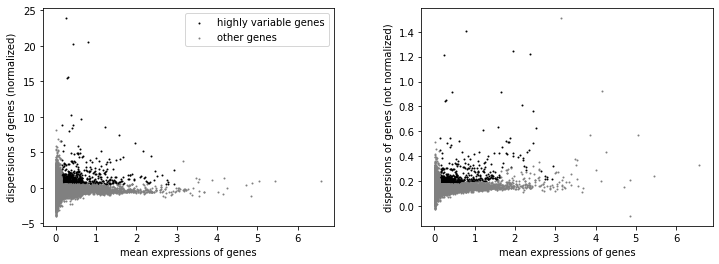

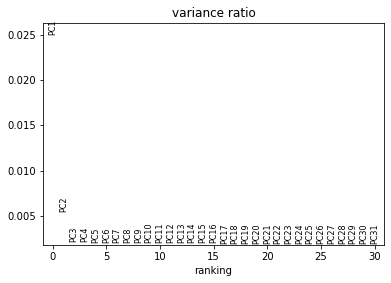

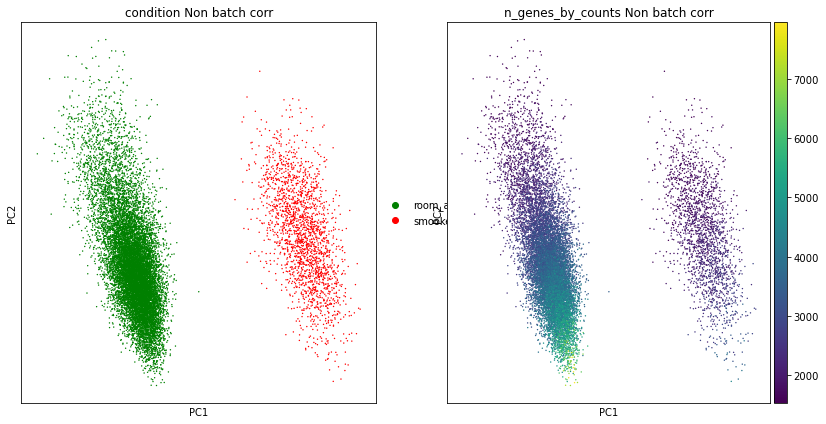

In [4]:
#Working with the non-corrected data
no_corr_adata=adata.copy()
print("COMPUTING PARAMETERS FOR NON-BATCH CORRECTED DATA.")
min_limit=990
max_limit=1200
go_break=5 #Number of times a new min_mean will not change the number of highly variable genes
num_pcs_for_plot=30 #Set the number of PCs for plot
####################################################################

old_sum=''
timer=''
old_min_mean=''
sum_nocor=''

####################################################################
#########NORMALIZE THE TOTAL COUNTS AND LOGARITIMIZE################
print("\nNORMALIZE THE TOTAL COUNTS AND LOGARITIMIZE")
sc.pp.normalize_total(no_corr_adata, target_sum = None, exclude_highly_expressed=True)
sc.pp.log1p(no_corr_adata)

####################################################################
##############ANNOTATING THE HIGHLY VARIABLE GENES##################
print("\nANNOTATING THE HIGHLY VARIABLE GENES")
def limiting(MIN_MEAN):
    global old_sum
    global timer
    global sum_nocor
    global old_min_mean
    sc.pp.highly_variable_genes(no_corr_adata, min_mean=MIN_MEAN) #the flavor='seurat_v3' will use read counts and not the logarithmyzed data. min_mean is ignored
    sum_nocor=sum(no_corr_adata.var.highly_variable)
    if old_sum != sum_nocor:
        old_sum=sum_nocor
        old_min_mean=MIN_MEAN
        timer=0
    else:
        timer=timer+1

min_mean=0.0125 #This is the default
limiting(min_mean)
while sum_nocor > max_limit:
    min_mean=min_mean*10
    limiting(min_mean)
    if timer == go_break:
        min_mean=old_min_mean
        break
while sum_nocor < min_limit:
    min_mean=min_mean/10
    limiting(min_mean)
    if timer == go_break:
        min_mean=old_min_mean
        break
print("The min_mean selected was: " + str(min_mean))
print("Highly variable genes without correction: " + str(sum_nocor))
#NOTE:
#"Depending on the task and the complexity of the dataset, typically between 1,000 and 5,000 HVGs are selected for downstream analysis..." (Luecken et al. 2019. DOI:10.15252/msb.20188746 )

####################################################################
##########################PLOTTING DATA#############################
print("\nCOMPUTING PCA AND PLOTING DATA")
#Computing PCA
sc.pp.pca(no_corr_adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)
#Plot mean-dispersion relationship and highly variable genes
sc.pl.highly_variable_genes(no_corr_adata,show=False)
#Plot PCA variance ratio for selection of PCs
sc.pl.pca_variance_ratio(no_corr_adata, n_pcs=num_pcs_for_plot, show=False)
#Plot PCA
n_rows = 1
n_cols = 2
fig, ((ax1, ax2)) = plt.subplots(n_rows, n_cols, figsize = (n_cols*7, n_rows*7))
sc.pl.pca(no_corr_adata, ax=ax1, color=[data_to_evaluate], palette = no_corr_adata.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate + " Non batch corr"], show=False)
sc.pl.pca(no_corr_adata, ax=ax2, color=['n_genes_by_counts'], title=["n_genes_by_counts" + " Non batch corr"], show=False)

**D1: Combat correction**

STARTING COMBAT BATCH EFFECT CORRECTION.

NORMALIZE THE TOTAL COUNTS, LOGARITIMIZE AND PERFORMING CORRECTION
The total size is 209198678
Checking adata.X before processing
    The Combat_adata.X presents:
       0 nan
       162004730 zeros
       0 negative
Runing normalization
    The Combat_adata.X presents:
       0 nan
       162004730 zeros
       0 negative
Runing logarithmizing
    The Combat_adata.X presents:
       0 nan
       162004730 zeros
       0 negative
Running Combat with covariate
	The obs used for batch effect removal is the condition
	The obs used for covariates is the pct_counts_is_mito
    The Combat_adata.X presents:
       0 nan
       0 zeros
       137564481 negative

ANNOTATING THE HIGHLY VARIABLE GENES
The min_mean selected for Combat was: 0.00125
Highly variable genes of anndata for Combat correction: 619

COMPUTING PCA AND PLOTING DATA


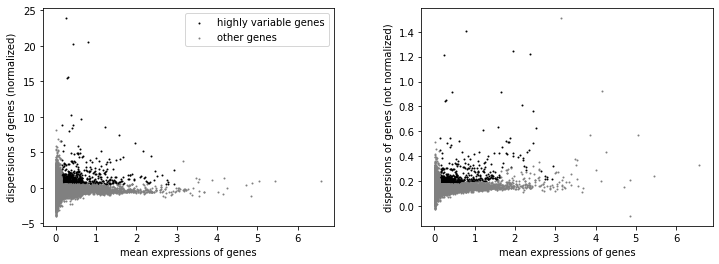

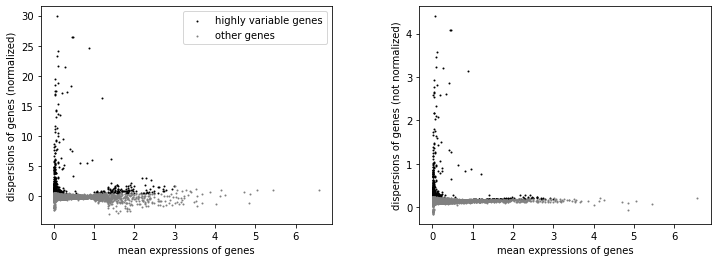

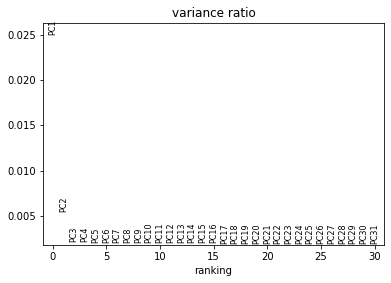

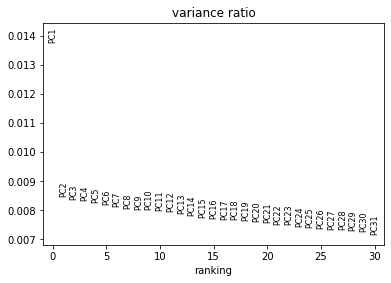

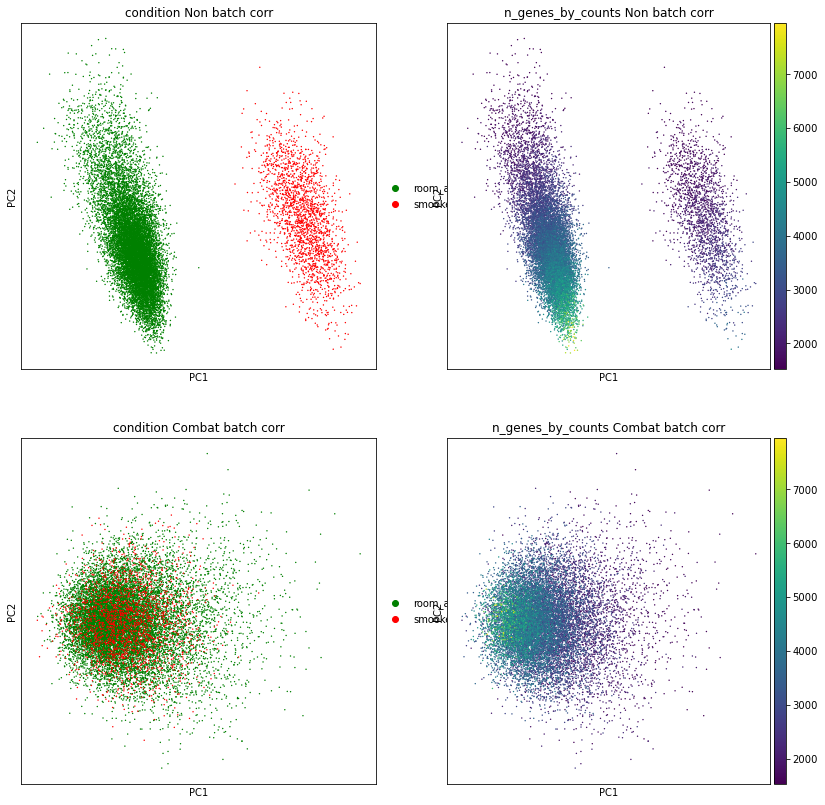

In [5]:
#Normalization and batch effect correction using Combat
if test_Combat_correction.split(":")[0] == "Yes":
    Combat_adata= adata.copy()
    #Working with combat data
    print("STARTING COMBAT BATCH EFFECT CORRECTION.")
    min_limit=990
    max_limit=1200
    go_break=5 #Number of times a new min_mean will not change the number of highly variable genes
    num_pcs_for_plot_combat=30 #Set the number of PCs for plot
####################################################################

    old_sum=''
    timer=''
    old_min_mean=''
    sum_combat=''
    one=no_corr_adata.shape[0]
    two=no_corr_adata.shape[1]
    sized=one*two

####################################################################
######NORMALIZE, LOGARITIMIZE AND PERFORMING CORRECTION#############
    print("\nNORMALIZE THE TOTAL COUNTS, LOGARITIMIZE AND PERFORMING CORRECTION")
    def check_Combat_adata(A, B):#Checking the presence of Nan, zeros and non-zeros in adata2.X
        global sized
        positive=A[np.where(A > 0)].size
        if positive == sized:
            print("    " + B + " can be applied to the Combat_adata without modifications")
        else:
            nans=np.sum(np.isnan(A))
            zeros=A[np.where(A == 0)].size
            negative=A[np.where(A < 0)].size
            if nans !=0 or zeros !=0 or negative !=0:
                print("    The Combat_adata.X presents:" + "\n       " + str(nans) + " nan" + "\n       " + str(zeros) + " zeros" + "\n       " + str(negative) + " negative")
    #Check raw data
    print("The total size is " + str(sized))
    print("Checking adata.X before processing")
    adataX_array=no_corr_adata.X.toarray()
    check_Combat_adata(adataX_array, "Raw")
    #Runing normalization
    print("Runing normalization")
    sc.pp.normalize_total(Combat_adata, target_sum = None, exclude_highly_expressed=True)
    adataX_array=Combat_adata.X.toarray()
    check_Combat_adata(adataX_array, "Normalization")
    #Logarithmize expression
    print("Runing logarithmizing")
    sc.pp.log1p(Combat_adata)
    adataX_array=Combat_adata.X.toarray()
    check_Combat_adata(adataX_array, "Logarithmizing")
    #Performing the batch effect correction
    print("Running Combat with covariate")
    print("\tThe obs used for batch effect removal is the " + test_Combat_correction.split(":")[1])
    print("\tThe obs used for covariates is the " + test_Combat_correction.split(":")[2])
    sc.pp.combat(Combat_adata, key=test_Combat_correction.split(":")[1], inplace=True, covariates=[test_Combat_correction.split(":")[2]])
    #Runing the function
    check_Combat_adata(Combat_adata.X, "Combat")

####################################################################
##############ANNOTATING THE HIGHLY VARIABLE GENES##################
    print("\nANNOTATING THE HIGHLY VARIABLE GENES")
    def limiting(MIN_MEAN):
        global old_sum
        global timer
        global sum_combat
        global old_min_mean
        sc.pp.highly_variable_genes(Combat_adata, min_mean=MIN_MEAN) #the flavor='seurat_v3' will use read counts and not the logarithmyzed data. min_mean is ignored
        sum_combat=sum(Combat_adata.var.highly_variable)
        if old_sum != sum_combat:
            old_sum=sum_combat
            old_min_mean=MIN_MEAN
            timer=0
        else:
            timer=timer+1

    min_mean=0.0125 #This is the default
    limiting(min_mean)
    while sum_combat > max_limit:
        min_mean=min_mean*10
        limiting(min_mean)
        if timer == go_break:
            min_mean=old_min_mean
            break
    while sum_combat < min_limit:
        min_mean=min_mean/10
        limiting(min_mean)
        if timer == go_break:
            min_mean=old_min_mean
            break
    print("The min_mean selected for Combat was: " + str(min_mean))
    print("Highly variable genes of anndata for Combat correction: " + str(sum_combat))

####################################################################
##########################PLOTTING DATA#############################
    print("\nCOMPUTING PCA AND PLOTING DATA")
    #Computing PCA
    sc.pp.pca(Combat_adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)
    #Plot mean-dispersion relationship and highly variable genes
    sc.pl.highly_variable_genes(no_corr_adata,show=False)
    sc.pl.highly_variable_genes(Combat_adata,show=False)
    # Plot PCA variance ratio for selection of PCs
    sc.pl.pca_variance_ratio(no_corr_adata, n_pcs=num_pcs_for_plot, show=False)
    sc.pl.pca_variance_ratio(Combat_adata, n_pcs=num_pcs_for_plot_combat, show=False)
    #Plot PCA
    n_rows = 2
    n_cols = 2
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(n_rows, n_cols, figsize = (n_cols*7, n_rows*7))
    sc.pl.pca(no_corr_adata, ax=ax1, color=[data_to_evaluate], palette = no_corr_adata.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate + " Non batch corr"], show=False)
    sc.pl.pca(no_corr_adata, ax=ax2, color=['n_genes_by_counts'], title=["n_genes_by_counts" + " Non batch corr"], show=False)
    sc.pl.pca(Combat_adata, ax=ax3, color=[data_to_evaluate], palette = Combat_adata.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate + " Combat batch corr"], show=False)
    sc.pl.pca(Combat_adata, ax=ax4, color=['n_genes_by_counts'], title=["n_genes_by_counts" + " Combat batch corr"], show=False)
else:
    print("This analysis was not selected.")

**D2: MNN correction**

- MNN come from Protocol published here: https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_03_integration.html with minor modifications.

STARTING MNN BATCH EFFECT CORRECTION.

NORMALIZE, AND LOGARITIMIZE

ANNOTATING THE HIGHLY VARIABLE GENES
The min_mean selected for MNN was: 0.00125
Highly variable genes of anndata for MNN correction: 1105

DEFINING THE BEST NUMBER OF BATCHES THAT SHARE HIGHER EXPRESSED GENES
The number of batches where highly expressed genes are available:
0    7314
1    5608
2    1105
Name: highly_variable_nbatches, dtype: int64

SELECTING GENES FOR MNN NORMALIZATION
The number of selected genes for correction MNN: 1105

EXECUTING MNN CORRECTION


/home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x7f0bb016a4c0>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2352.
    With argument(s): '(x=array(float32, 2d, A), axis=int64)':
   Rejected as the implementation raised a specific error:
     TypeError: norm_impl() got an unexpected keyword argument 'x'
  raised from /home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/numba/core/typing/templates.py:722

During: resolving callee type: Function(<function norm at 0x7f0bb016a4c0>)
During: typing of call at /home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/mnnpy/u

/home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "adjust_s_variance" was compiled in object mode without forceobj=True, but has lifted loops.

File "../../../.conda/envs/scRNAseq/lib/python3.8/site-packages/mnnpy/utils.py", line 201:
def adjust_s_variance(data1, data2, curcell, curvect, sigma):
    distance1 = np.zeros((data1.shape[0], 2), dtype=np.float32)
    ^

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../../.conda/envs/scRNAseq/lib/python3.8/site-packages/mnnpy/utils.py", line 201:
def 

Performing cosine normalization...


/home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x7f0bb016a4c0>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
    - Of which 2 did not match due to:
    Overload in function 'norm_impl': File: numba/np/linalg.py: Line 2352.
      With argument(s): '(x=array(float32, 2d, A), axis=int64)':
     Rejected as the implementation raised a specific error:
       TypeError: norm_impl() got an unexpected keyword argument 'x'
  raised from /home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/numba/core/typing/templates.py:722

During: resolving callee type: Function(<function norm at 0x7f0bb016a4c0>)
During: typing of call at /home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packag

Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...


/home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/mnnpy/utils.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/mnnpy/utils.py (94)

File "../../../.conda/envs/scRNAseq/lib/python3.8/site-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8))
/home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "find_mutual_nn" was compiled in object mode without forceobj=True.

File "../../../.conda/envs/scRNAseq/lib/python3.8/site-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source

  Computing correction vectors...


/home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/mnnpy/utils.py:102: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "compute_correction" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/mnnpy/utils.py (107)

File "../../../.conda/envs/scRNAseq/lib/python3.8/site-packages/mnnpy/utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  @jit(float32[:, :](float32[:, :], float32[:, :], int32[:], int32[:], float32[:, :], float32))
/home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "compute_correction" was compiled in object mode without forceobj=True.

File "../../../.conda/

  Removing components...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.

ANNOTATING THE HIGHLY VARIABLE GENES AFTER MNN CORRECTION


/home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/gvalent/.conda/envs/scRNAseq/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


The min_mean selected after MNN correction was: 1.25e-05
Highly variable genes of anndata after MNN correction: 2141

COMPUTING PCA AND PLOTING DATA


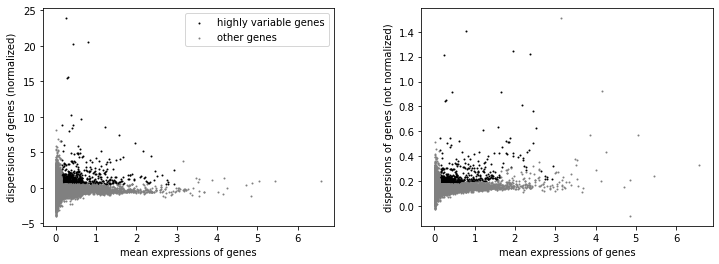

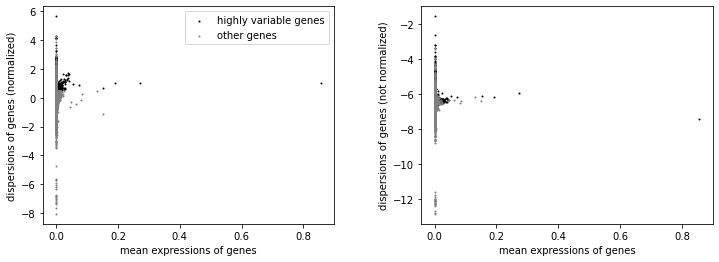

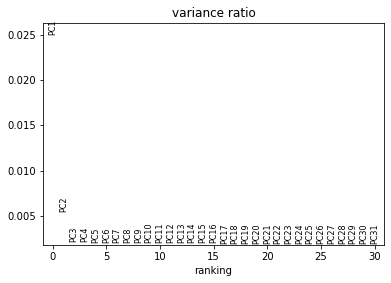

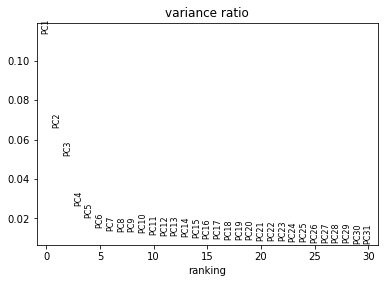

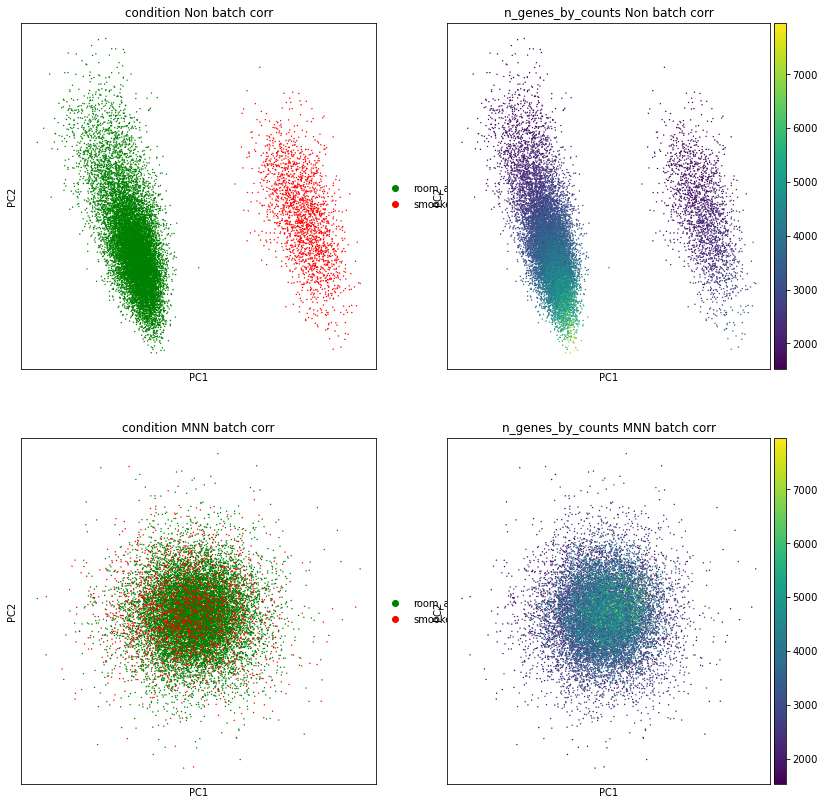

In [6]:
#Performing the MNN correction
if test_MNN_adata.split(":")[0] == "Yes":
    MNN_adata= adata.copy()
    #Working with MNN data
    print("STARTING MNN BATCH EFFECT CORRECTION.")
    min_limit=990
    max_limit=1200
    go_break=5 #Number of times a new min_mean will not change the number of highly variable genes
    num_pcs_for_plot_mnn=30 #Set the number of PCs for plot
####################################################################

    old_sum=''
    timer=''
    old_min_mean=''
    sum_mnn=''

####################################################################
################NORMALIZE, AND LOGARITIMIZE#########################
    print("\nNORMALIZE, AND LOGARITIMIZE")
    sc.pp.normalize_total(MNN_adata, target_sum = None, exclude_highly_expressed=True)
    sc.pp.log1p(MNN_adata)

####################################################################
##############ANNOTATING THE HIGHLY VARIABLE GENES##################
    print("\nANNOTATING THE HIGHLY VARIABLE GENES")
    def limiting(MIN_MEAN):
        global old_sum
        global timer
        global sum_mnn
        global old_min_mean
        sc.pp.highly_variable_genes(MNN_adata, min_mean=MIN_MEAN, batch_key=data_to_evaluate)
        sum_mnn=sum(MNN_adata.var.highly_variable_intersection)
        if old_sum != sum_mnn:
            old_sum=sum_mnn
            old_min_mean=MIN_MEAN
            timer=0
        else:
            timer=timer+1

    min_mean=0.0125 #This is the default
    limiting(min_mean)
    while sum_mnn > max_limit:
        min_mean=min_mean*10
        limiting(min_mean)
        if timer == go_break:
            min_mean=old_min_mean
            break
    while sum_mnn < min_limit:
        min_mean=min_mean/10
        limiting(min_mean)
        if timer == go_break:
            min_mean=old_min_mean
            break
    print("The min_mean selected for MNN was: " + str(min_mean))
    print("Highly variable genes of anndata for MNN correction: " + str(sum_mnn))
#NOTE:
#"Depending on the task and the complexity of the dataset, typically between 1,000 and 5,000 HVGs are selected for downstream analysis..." (Luecken et al. 2019. DOI:10.15252/msb.20188746 )

####################################################################
################DEFININING THE NUMBER OF BATCHES####################
    print("\nDEFINING THE BEST NUMBER OF BATCHES THAT SHARE HIGHER EXPRESSED GENES")
    print("The number of batches where highly expressed genes are available:")
    print(MNN_adata.var.highly_variable_nbatches.value_counts())
    num_batchs_sel=MNN_adata.var.highly_variable_nbatches.value_counts()[MNN_adata.var.highly_variable_nbatches.value_counts() == sum_mnn].index[0] #Here is number of batches a given gene must be to be selected.

####################################################################
##############SELECTING GENES FOR MNN NORMALIZATION#################
    print("\nSELECTING GENES FOR MNN NORMALIZATION")
    while num_batchs_sel > len(MNN_adata.obs[data_to_evaluate].unique()):
        if num_batchs_sel < 0:
            print("There is something wrong since the number of selected batches is negative. Check the MNN_adata object.")
            break
        else:
            print("There is up to " + str(len(MNN_adata.obs[data_to_evaluate].unique())) + " batches. The number of selected batches will be reduced.")
            num_batchs_sel=num_batchs_sel-1
    #Select all genes that are variable in at least X datasets and use them for the remaining analysis.
    var_select=MNN_adata.var.highly_variable_nbatches >= num_batchs_sel
    var_genes=var_select.index[var_select]
    print("The number of selected genes for correction MNN: " + str(len(var_genes)))
    #Splitting each object in separated lists
    datasets=[adata[adata.obs[data_to_evaluate]==a].copy() for a in adata.obs[data_to_evaluate].cat.categories]
    batches=no_corr_adata.obs[data_to_evaluate].cat.categories.tolist()

####################################################################
#######################MAKING MNN CORRECTION########################
    print("\nEXECUTING MNN CORRECTION")
    cdata=sc.external.pp.mnn_correct(*datasets, svd_dim=50, batch_key=data_to_evaluate, save_raw=True, var_subset=var_genes, batch_categories=batches, n_jobs=num_processors)
    #Copying anndata after MNN
    MNN_adata2=cdata[0]
    MNN_adata2.uns[data_to_evaluate + '_colors']=color_list

####################################################################
##############ANNOTATING THE HIGHLY VARIABLE GENES##################
    print("\nANNOTATING THE HIGHLY VARIABLE GENES AFTER MNN CORRECTION")
    old_sum=''
    timer=''
    old_min_mean=''
    sum_mnn=''
    def limiting(MIN_MEAN):
        global old_sum
        global timer
        global sum_mnn
        global old_min_mean
        sc.pp.highly_variable_genes(MNN_adata2, min_mean=MIN_MEAN, batch_key=data_to_evaluate)
        sum_mnn=sum(MNN_adata2.var.highly_variable)
        if old_sum != sum_mnn:
            old_sum=sum_mnn
            old_min_mean=MIN_MEAN
            timer=0
        else:
            timer=timer+1

    min_mean=0.0125 #This is the default
    limiting(min_mean)
    while sum_mnn > max_limit:
        min_mean=min_mean*10
        limiting(min_mean)
        if timer == go_break:
            min_mean=old_min_mean
            break
    while sum_mnn < min_limit:
        min_mean=min_mean/10
        limiting(min_mean)
        if timer == go_break:
            min_mean=old_min_mean
            break
    print("The min_mean selected after MNN correction was: " + str(min_mean))
    print("Highly variable genes of anndata after MNN correction: " + str(sum_mnn))

####################################################################
##########################PLOTTING DATA#############################
    print("\nCOMPUTING PCA AND PLOTING DATA")
    #Computing PCA
    sc.pp.pca(MNN_adata2, svd_solver='arpack', n_comps=50, use_highly_variable=True)
    #Plot mean-dispersion relationship and highly variable genes
    sc.pl.highly_variable_genes(no_corr_adata,show=False)
    sc.pl.highly_variable_genes(MNN_adata2,show=False)
    #Plot PCA variance ratio for selection of PCs
    sc.pl.pca_variance_ratio(no_corr_adata, n_pcs=num_pcs_for_plot, show=False)
    sc.pl.pca_variance_ratio(MNN_adata2, n_pcs=num_pcs_for_plot_mnn, show=False)
    #Plot PCA
    n_rows = 2
    n_cols = 2
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(n_rows, n_cols, figsize = (n_cols*7, n_rows*7))
    sc.pl.pca(no_corr_adata, ax=ax1, color=[data_to_evaluate], palette = no_corr_adata.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate + " Non batch corr"], show=False)
    sc.pl.pca(no_corr_adata, ax=ax2, color=['n_genes_by_counts'], title=["n_genes_by_counts" + " Non batch corr"], show=False)
    sc.pl.pca(MNN_adata2, ax=ax3, color=[data_to_evaluate], palette = MNN_adata2.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate + " MNN batch corr"], show=False)
    sc.pl.pca(MNN_adata2, ax=ax4, color=['n_genes_by_counts'], title=["n_genes_by_counts" + " MNN batch corr"], show=False)
#NOTE:
#"Depending on the task and the complexity of the dataset, typically between 1,000 and 5,000 HVGs are selected for downstream analysis..." (Luecken et al. 2019. DOI:10.15252/msb.20188746 )

else:
    print("This analysis was not selected.")

**D3: Overview comparing non corrected, Combate and MNN batch corrected**

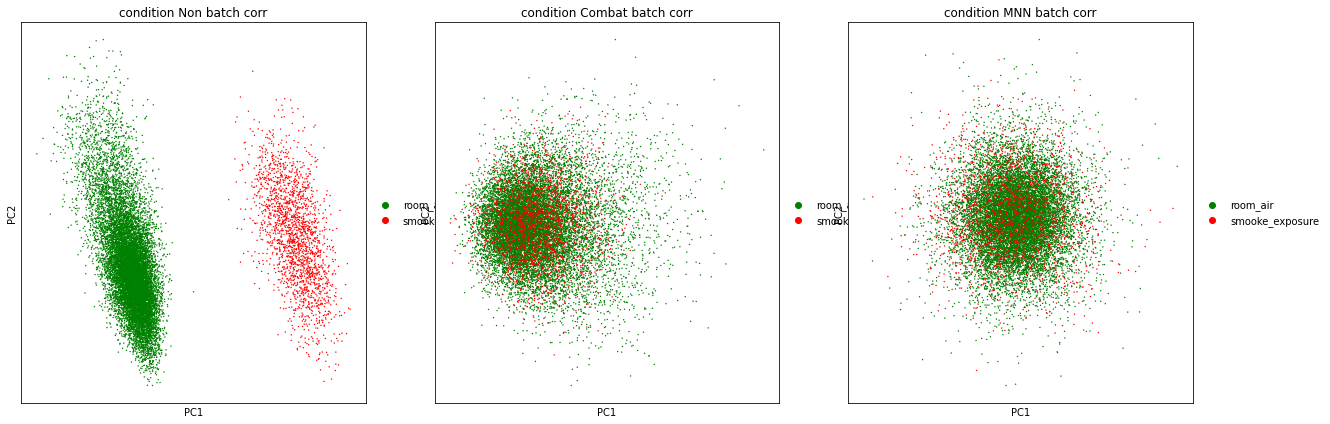

In [7]:
#General PCA of datasets
def ploting_data(ROWS, COLS):
    global axs
    global filename
    global path
    filename="pca_noncorrected_batch_corrected_data.png"
    path=path_results + "/" + filename
    num_colors=len(no_corr_adata.obs[data_to_evaluate].cat.categories)
    if int(num_colors) <= int(len(color_list)):
        n_rows=ROWS
        n_cols=COLS
        axs=["ax" + str(a) for a in list(range(1, n_cols+1))]
        fig, (axs)=plt.subplots(n_rows, n_cols, figsize = (n_cols*7, n_rows*7))
    
if test_Combat_correction.split(":")[0] == "Yes" and test_MNN_adata.split(":")[0] == "Yes":
    ploting_data(1, 3)
    sc.pl.pca(no_corr_adata, ax=axs[0], color=[data_to_evaluate], palette = no_corr_adata.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate + " Non batch corr"], show=False)
    sc.pl.pca(Combat_adata, ax=axs[1], color=[data_to_evaluate], palette = Combat_adata.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate + " Combat batch corr"], show=False)
    sc.pl.pca(MNN_adata2, ax=axs[2], color=[data_to_evaluate], palette = MNN_adata2.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate + " MNN batch corr"], show=False)
    plt.savefig(path)

elif test_Combat_correction.split(":")[0] == "Yes" and test_MNN_adata.split(":")[0] == "No":
    ploting_data(1, 2)
    sc.pl.pca(no_corr_adata, ax=axs[0], color=[data_to_evaluate], palette = no_corr_adata.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate + " Non batch corr"], show=False)
    sc.pl.pca(Combat_adata, ax=axs[1], color=[data_to_evaluate], palette = Combat_adata.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate + " Combat batch corr"], show=False)
    plt.savefig(path)

elif test_Combat_correction.split(":")[0] == "No" and test_MNN_adata.split(":")[0] == "Yes":
    ploting_data(1, 2)
    sc.pl.pca(no_corr_adata, ax=axs[0], color=[data_to_evaluate], palette = no_corr_adata.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate + " Non batch corr"], show=False)
    sc.pl.pca(MNN_adata2, ax=axs[2], color=[data_to_evaluate], palette = MNN_adata2.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate + " MNN batch corr"], show=False)
    plt.savefig(path)
else:
    print("This analysis was not selected.")

**D4: Defining the best set**

Choose MNN corrected.
Saving the anndata.


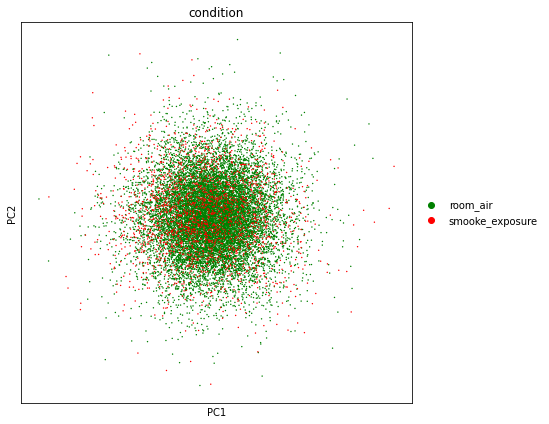

In [8]:
#Which anndata did you choose?
choose_non_corrected="No"
choose_Combat_correction="No"
choose_MNN_correction="Yes"
######################

path=path_results + "/" + "pca_final_anndata.png"

######################
yes=0
no=0
un=0
list_conds=[choose_non_corrected, choose_Combat_correction, choose_MNN_correction]
timer=0
def checking1(A, B, C):
    if A == "Yes" or A == "No":
        pass
    else:
        print("WARNING: Choose Yes or No for variable " + C[B])

for a in list_conds:
    if a == "Yes":
        yes=yes+1
    elif a == "No":
        no=no+1
    else:
        un=un+1
if un > 0:
    print("WARNING: One variable is not assigned as Yes or No.")
elif no == 3:
    print("WARNING: You must set at least one variable as Yes.")
elif yes > 1:
    print("WARNING: More than one variable is assigned as Yes.")
else:
    if choose_non_corrected == "Yes":
        print("Choose non-corrected.")
        adata=no_corr_adata.copy()
    else:
        if choose_Combat_correction == "Yes":
            print("Choose Combat corrected.")
            adata=Combat_adata.copy()
            name="Combat"
        elif choose_MNN_correction == "Yes":
            print("Choose MNN corrected.")
            adata=MNN_adata2.copy()
            name="MNN"
    n_rows = 1
    n_cols = 1
    fig, (ax1) = plt.subplots(n_rows, n_cols, figsize = (n_cols*7, n_rows*7))
    ax1_dict=sc.pl.pca(adata, ax=ax1, color=[data_to_evaluate], palette = adata.uns[data_to_evaluate + '_colors'], title=[data_to_evaluate], show=False)
    plt.savefig(path)

#Saving the anndata
print("Saving the anndata.")
adata_output= path_results + "/anndata_3_" + test +".h5ad"
adata.write(filename=adata_output)

# E: Saving information

In [9]:
display(adata)
displayoutput=str(adata)
information="\n3_batch\n" + "\nOutput_3:anndata_3_" + test + ".h5ad" + "\nAnndata:\n" + displayoutput
print(information, file=open(path_results + "/information.txt", "a"))

AnnData object with n_obs × n_vars = 14914 × 14027
    obs: 'condition', 'n_genes_by_counts', 'log1p_total_counts', 'pct_counts_is_mito', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'is_mito', 'n_cells_by_counts', 'log1p_mean_counts', 'mean_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'condition_colors', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced'